# 3D spatial mapping of labelled neurons in a mouse brain atlas
### This notebook will average the number of neurons mapped in 3D coordiantes based on the chon atlas after SHARCQ analysis 

Input needed:
a .csv file of the 'brainpoints' file wanting to be visualized. 
The file will need an 'ap' column, a 'ml' column, and a 'dv' column. 
'groups' column will be used to separate color scale, and can be set by any metric decided by the experimenter. 

Updated 11-17-23 SM

*note: to read and improve notebook organization, source- https://ploomber.io/blog/clean-nbs/

## Notebook analysis: Table of Contents
#### This noteboook is just the code to decide which groups to graph and visualize, all extra code and documentation will be removed to condense

**_________________________________________________________________________________________________________________________**

# Setup:
1. Import all needed python libraries
2. input file storage information
3. Decide on color coding for group values 

### 1. Import Libraries

In [1]:
#Import all needed libraries 

#Libraries to read and format data
import numpy as np
import pandas as pd
import open3d as o3d

#libraries for genreating figures
%matplotlib ipympl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
from pandas.api.types import CategoricalDtype 
from collections import Counter

#Libraries for clustering analysis 
from sklearn.cluster import DBSCAN #import density clustering calculations
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans #kmean clustering analysis
import seaborn as sns #visualizing statistics
from itertools import combinations #Calculating groups combinations at later steps

#Libraries for creating tables
from tabulate import tabulate 
from prettytable import PrettyTable 

#deactivate warning signs that can spam code later in section due to changes in code updates
import warnings
warnings.filterwarnings("ignore")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### 2. Set path for project file folder and choose data analysis file


In [2]:
#DEFINE PATH of project folder
my_path = ("C:/Users/Mullo/Documents")

#DEFINED project subfolders
output = "/output"
raw_data= "/Raw Data"
output_figures= "/output/Figures"
output_tables= "/output/Tables"
output_datafiles= "/output/DataFiles"

#Input: files for generating representative brain clusters
my_analysis_file = ("/M_chat_all_python.csv")
my_analysis_file_nocsv = "/M_chat_all_python"
#Input: files for analyzing labelled points of interest (POI)
my_analysis_file_POI = "/M_chatfos_ByTreatment.csv"
my_analysis_file_POI_nocsv = "/ M_chatfos_ByTreatment"

#Setup standard variables for all saved files 
date = pd.to_datetime('now').strftime("%Y-%m-%d")
file_date_name= '({name})'.format(name=date)

### 3. Set up color code for visualzing treatment groups

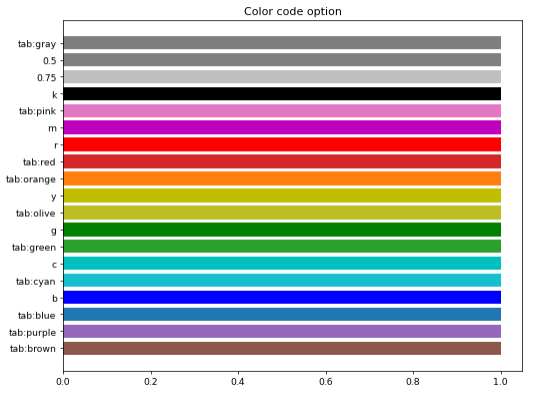


In [3]:
print("How Many Groups?")
num= input()
Total_Number_groups= int(num)+1
print("")

group_number_ID= []
for groupN in range (1,Total_Number_groups):
    group_number_ID.append(groupN)
print("Number of groups set=", len(group_number_ID), group_number_ID)
print("")

print("What is the GroupID number for each treatment category? (note: must match analysis file)")
GroupID_set=[]
for ID in range (1, Total_Number_groups):
    output_ID=input(ID)
    GroupID_set.append(output_ID)
print ("Group ID set=", GroupID_set)
print("")

print("What is Treatment Label for each Group ID? (Note: must exactly match text on analysis file)")
TrLabel_set=[]
for Label in range (1, Total_Number_groups):
    output_label=input(Label)
    TrLabel_set.append(output_label)
print("Treatment Labels set=", TrLabel_set)
print("")

print("What color do you want each group/treatment to be coded? Input text code listed in reference figure")
color_code= []
for color in range (1, Total_Number_groups):
    output_color = input(color)
    color_code.append(output_color)
print("Color code set=", color_code)

How Many Groups?


 7



Number of groups set= 7 [1, 2, 3, 4, 5, 6, 7]

What is the GroupID number for each treatment category? (note: must match analysis file)


1 1
2 2
3 3
4 4
5 5
6 6
7 7


Group ID set= ['1', '2', '3', '4', '5', '6', '7']

What is Treatment Label for each Group ID? (Note: must exactly match text on analysis file)


1 1d sal
2 5d sal
3 15d sal
4 1d 2et
5 5d 2et
6 15d 2et
7 1d 4et


Treatment Labels set= ['1d sal', '5d sal', '15d sal', '1d 2et', '5d 2et', '15d 2et', '1d 4et']

What color do you want each group/treatment to be coded? Input text code listed in reference figure


1 0.5
2 0.5
3 0.5
4 b
5 g
6 tab:purple
7 tab:red


Color code set= ['0.5', '0.5', '0.5', 'b', 'g', 'tab:purple', 'tab:red']


### Create reference tables of parameters set during setup- rerun setup steps if anything is inaccurate

In [4]:
#Create table summarize 
TableTitle= 'Table: Color code set for each group'
print(TableTitle)
Table_colorcode= PrettyTable(['Group ID', 'Treatment Label', 'color code'])
for more in range (0,Total_Number_groups-1):
    Table_colorcode.add_row([GroupID_set[more], TrLabel_set[more], color_code[more]])
print(Table_colorcode)

#Create a dataframe to store these reference values 
setup_RefGroup= pd.DataFrame({"Group ID":GroupID_set, "Treatment Label":TrLabel_set, "Color Code":color_code})
print("")
#setup_RefGroup.index= setup_RefGroup(['Group ID'], axis=1)

Table: Color code set for each group
+----------+-----------------+------------+
| Group ID | Treatment Label | color code |
+----------+-----------------+------------+
|    1     |      1d sal     |    0.5     |
|    2     |      5d sal     |    0.5     |
|    3     |     15d sal     |    0.5     |
|    4     |      1d 2et     |     b      |
|    5     |      5d 2et     |     g      |
|    6     |     15d 2et     | tab:purple |
|    7     |      1d 4et     |  tab:red   |
+----------+-----------------+------------+



**_________________________________________________________________________________________________________________________**

# Part 1: Generate representative brain (condensed)

#### run Kmeans cluster analysis and create needed dataframes for next analysis steps (condensed from 'rep brain' notebook

In [5]:
df2 = pd.read_csv(my_path + raw_data+ my_analysis_file) #Import files to pandas dataframe from local computer path
dataset_xyz = df2[['ap','dv','ml']].values #Create 3D matrix for analysis 

cell_number = df2.groupby(['animal'])['groups'].count() 
cell_number_listed = cell_number.tolist()
animal_listed = df2['animal'].unique()
print("Summary of cell number for each animal:") 

#Manually input number of clusters based on the updated average 
cluster_number= round(cell_number.mean())

#Input cluster number into the model and generate a k-means clustering model from the XYZ coordiantes
km_model = KMeans(n_clusters = cluster_number, init = "k-means++", max_iter = 300, n_init = 20, random_state = 0)
y_clusters = km_model.fit(dataset_xyz)
model_clusters = y_clusters.fit_predict(dataset_xyz)

#Add cluster ID to the main dataset- create new dataframe
data_cluster= pd.DataFrame({'section_ap':dataset_xyz[:,0], 'dv':dataset_xyz[:,1], 'ml':dataset_xyz[:,2], 'km_cluster_id':km_model.labels_})
#Import information on cluster centroids 
centroids = km_model.cluster_centers_
#create list of all cluster IDs
km_sortclusterID = data_cluster.sort_values(by=['km_cluster_id'])
k_model_clusterID= km_sortclusterID['km_cluster_id'].unique().tolist()
#create centroid dataset for future analysis 
km_cent=pd.DataFrame({'cluster ID':k_model_clusterID, 'ap':centroids[:,0], 'dv':centroids[:,1], 'ml':centroids[:,2]})
km_cent.index=km_cent['cluster ID']

Summary of cell number for each animal:


***-----------------------------------------------------------------------------------------------------------------------***

### Part 2: Identify Neuronal space(cluster) of neurons by label/category of interest (POI) (condensed)

In [6]:
#Import files to pandas dataframe from local computer path
data_POI= pd.read_csv(my_path + raw_data + my_analysis_file_POI)
colorcode_gID= setup_RefGroup['Group ID'].unique().astype('str')
colorcode_Treat= setup_RefGroup['Treatment Label'].unique().astype('str')
colorcode_color = setup_RefGroup['Color Code'].tolist()

#Create matrix of labelled clusters to be tested in model 
POI_xyz = data_POI[['ap','dv','ml']].values

#Use established model to output predicted cluster values for new dataset
predict_POI_cluster = km_model.predict(POI_xyz)
predict_cluster= predict_POI_cluster.tolist()

#Add cluster ID to the main dataset
POIdata_cluster= pd.DataFrame({'section_ap':POI_xyz[:,0], 'dv':POI_xyz[:,1], 'ml':POI_xyz[:,2], 'treatment':data_POI['treatment'],'groups':data_POI['groups'],'predicted cluster id':predict_cluster})
POIdata_cluster.index.name= "datapoint"

#split cluster ID by treatment groups 
clusterID_all= POIdata_cluster['predicted cluster id']

#Input cluster coordinates for predicted ID
model_cID= km_cent['cluster ID']
model_cap= km_cent['ap']
model_cml=km_cent['ml']
model_cdv=km_cent['dv']

#generate iterable output coordinates for each cluster ID
c_ID= []
c_ap= []
c_ml=[]
c_dv=[]
for point in range (0, len(clusterID_all)):
    datapoint_eval= clusterID_all[point]
    for mpnt in range (0, len(model_cID)):
        compare= model_cID[mpnt]
        temp_ap= model_cap[mpnt]
        temp_ml= model_cml[mpnt]
        temp_dv= model_cdv[mpnt]
        if datapoint_eval == compare:
            c_ID.append(compare)
            c_ap.append(temp_ap)
            c_ml.append(temp_ml)
            c_dv.append(temp_dv)
        else:
            pass

#add cluster centroid into dataframe 
POIdata_cluster["centroid ID"]= c_ID
POIdata_cluster["centroid ap"]= c_ap
POIdata_cluster["centroid ml"]= c_ml
POIdata_cluster["centroid dv"]= c_dv


____________________________________________________________________________

# Visualized predicted cluster for specific groups

How many treatment groups do you want to compare?


 2


What treatment groups do you want to compare?
options: ['1d sal', '5d sal', '15d sal', '1d 2et', '5d 2et', '15d 2et', '1d 4et']


0 1d sal
1 1d 2et


Treatments to be compared: ['1d sal', '1d 2et']


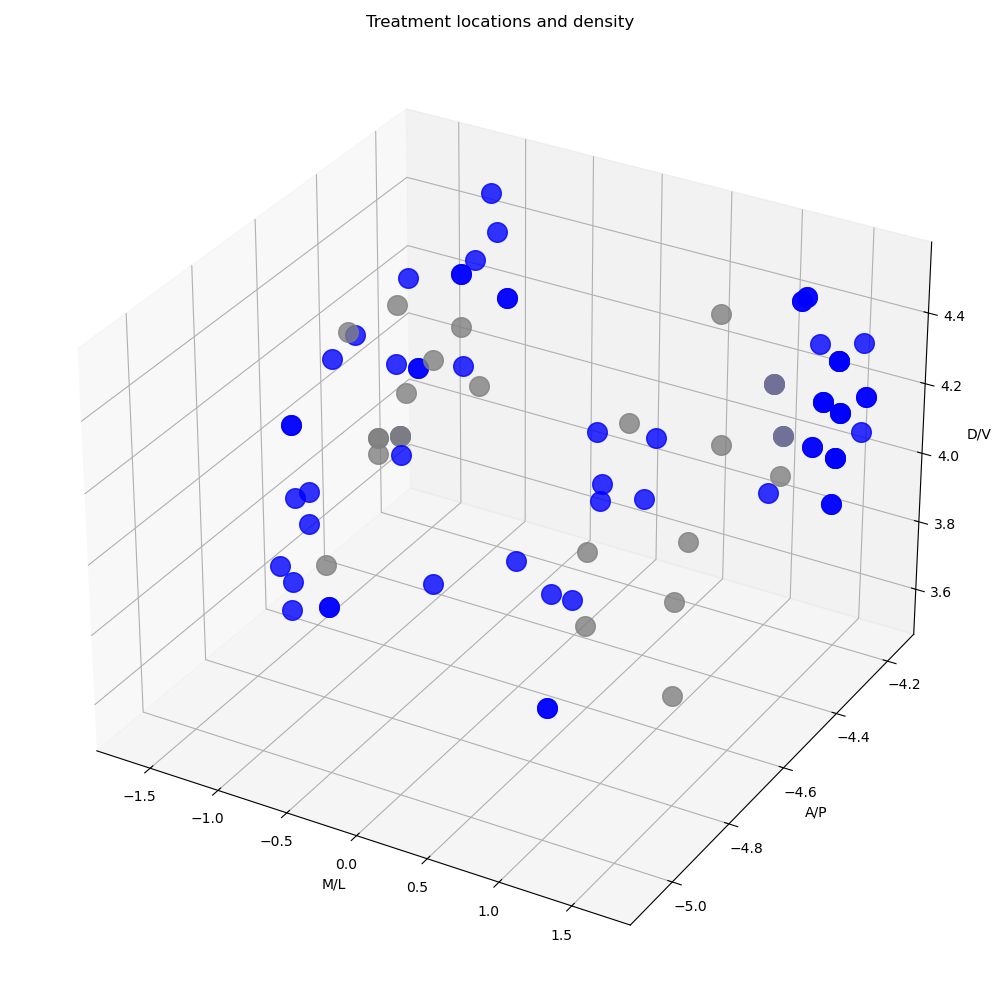

In [8]:
print("How many treatment groups do you want to compare?")
compare_number= int(input())

#Input the treatments you want to compare:
print("What treatment groups do you want to compare?")
print("options:", setup_RefGroup['Treatment Label'].tolist())

plot_tocompare=[]
for yay in range (0, compare_number):
    compare_treat= input(yay)
    plot_tocompare.append(compare_treat)
print("Treatments to be compared:", plot_tocompare)

#Generate the plot based on the input variables 

#Define group numbers based on the input treatment groups 
grnum_compare= []
for yes in range (0, compare_number):
    refvalue= plot_tocompare[yes]
    for tada in range (0, len(colorcode_Treat)):
        ref_treat= colorcode_Treat[tada]
        ref_gnum= colorcode_gID[tada]
        if refvalue == ref_treat:
            grnum_compare.append(ref_gnum)
        else:
            pass

#create figure and variables 

FigureTitle = "Treatment locations and density"
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig_scalecompare = plt.figure()
ax_scp = fig_scalecompare.add_subplot(projection="3d")
ax_scp.set_xlabel('M/L')
ax_scp.set_ylabel('A/P')
ax_scp.set_zlabel('D/V')
plt.title(FigureTitle)

#input selected groups only 
for rp in range (0, len(POIdata_cluster)):
    x_plot= POIdata_cluster['centroid ml'][rp]
    y_plot= POIdata_cluster['centroid ap'][rp]
    z_plot= POIdata_cluster['centroid dv'][rp]
    ref_treatID= POIdata_cluster['groups'][rp]
    for grID in range (0, len(colorcode_gID)):
        ref_num= colorcode_gID[grID]
        ref_color= colorcode_color[grID]
        for tehe in range (0, len(grnum_compare)):
            select_num= grnum_compare[tehe]
            if ref_num == select_num:
                if ref_treatID == int(ref_num):
                    ax_scp.scatter(x_plot, y_plot, z_plot, marker='o', s=200, alpha=0.8, c=ref_color)
                else:
                    pass
            else:
                pass
plt.show()